# Building a Cat Detector based on the pre-trained VGG16 network

Key words
- Transfer Learning
- Keras
- Tensorflow
- Queues and Threads
- 

## Introduction

Sources used:
- [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
- [keras-workshop](https://github.com/gggdomi/keras-workshop/blob/master/notebook.ipynb)

![]()

## Approach (bottlenecking)

As I don't have much images of cats that I can use for training the model I will use a pre-trained model VGG16 which amongst others is trained on cats.

Because I don't need all classes as an output I need to tweak the model a little for my objective. The technique I will use is called *bottlenecking* and works as follows; take the VGG16 network with all its weights but without the fully connected top layers and run the training and validation images through it. Store the generated outputsto a file. Use these outputs as input for a custom top layer model. Keep the trained weights of this trained model and we have a modified model that is trained for our custom purpose.

![VGG architecture full.](images/vgg16_original.png)

## Training

Inputs:
- Training dataset
- Validation dataset

Actions:
- Load VGG16 net without FC layers
- Feed the training and validation dataset to the network
- Save per dataset the bottleneck features into a numpy file
- Define a custom top network
- Train the custom network with the bottleneck features 
- Save the trained weights of the custom network

Outputs:
- Training bottleneck features (npy file)
- Validation bottleneck features (npy file)
- Trained weights for custom network (h5 file)

## Test and Evaluation

TODO

## Scoring

TODO

## Libraries required

In [1]:
import os
from tqdm import tqdm
import numpy as np

import tensorflow as tf
from tensorflow.contrib.keras.api.keras.applications import VGG16
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras.models import Sequential, Model, save_model, load_model
from tensorflow.contrib.keras.python.keras.layers import Dropout, Flatten, Dense, Input

In [2]:
# Set log level to INFO to get output while training.
tf.logging.set_verbosity(tf.logging.INFO)

### Paths and variables

In [2]:
train_dir = "data/train"
validation_dir = "data/validation"
test_dir = "data/test_labeled"

# bottleneck featureset filenames
bottleneck_features_train = 'bottleneck_features_train.npy'
bottleneck_features_validation = 'bottleneck_features_validation.npy'
bottleneck_features_test = 'bottleneck_features_test.npy'

# custom model weights filename
top_model_weights_path = 'bottleneck_fc_model.h5'
top_model_path = 'top_model.h5'

img_width, img_height = 150, 150
batch_size = 16
epochs = 50

nb_train_samples = 2000 # 1000 cats, 1000 dogs
nb_validation_samples = 800 # 400 cats, 400 dogs
nb_test_samples = 1008 # 504 cats, 504 dogs

### Functions for reuse

A pre trained model of VGG16 will be used for scoring custom images. The fully connected layers of this model will not be used as we will retrain or use our own top model. This way we can re-use the vgg features for our own class set (Transfer Learning)

## Step 1: Train and Test

### Create bottleneck features for Train and Validation set using the VGG16 model

In [16]:
%%timeit -n1 -r1
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network without the FC layers
model = VGG16(include_top=False, weights='imagenet')

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features = model.predict_generator(train_generator, nb_train_samples//batch_size)
print("VGG16 train bottleneck features calculated.")

np.save(open(bottleneck_features_train, 'wb'), bottleneck_features)
print("Training samples saved.")

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features = model.predict_generator(validation_generator, nb_validation_samples//batch_size)
print("VGG16 validation bottleneck features calculated.")

np.save(open(bottleneck_features_validation, 'wb'), bottleneck_features)
print("Validation samples saved.")

In [17]:
#

Found 2000 images belonging to 2 classes.
VGG16 train bottleneck features calculated.
Training samples saved.
Found 800 images belonging to 2 classes.
VGG16 validation bottleneck features calculated.
Validation samples saved.
12min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now we can use the saved bottleneck features without having the whole VGG network in memory and train our custom top model.

### Define and train the Top Model

In [18]:
# To save intermediate results
from tensorflow.contrib.keras.python.keras.callbacks import ModelCheckpoint

In [24]:
from tensorflow.contrib.keras.python.keras.models import save_model, load_model

**Load bottleneck features**

In [19]:
# Load the pre-calculated bottleneck features
train_data = np.load(open(bottleneck_features_train, 'rb'))
train_labels = np.array([0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

validation_data = np.load(open(bottleneck_features_validation, 'rb'))
validation_labels = np.array([0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

In [20]:
train_data.shape

(2000, 4, 4, 512)

In [21]:
validation_data.shape

(800, 4, 4, 512)

**Define Top Layer Model**

In [22]:
# Define the top model
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print("Top model compiled.")

Top model compiled.


**Train Top Layer Model and save checkpoints and final model + weights**

In [23]:
# Define checkpoints only when the validation accuracy improves
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             period=1)

callbacks_list = [checkpoint]

top_model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels),
          callbacks=callbacks_list)

top_model.save_weights(top_model_weights_path)
print("Trained top-model weights saved as: {}".format(top_model_weights_path))

# Save the model
save_model(top_model, top_model_path)
print("Top-model  saved as: {}".format(top_model_path))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 4s - loss: 0.7149 - acc: 0.7500 - val_loss: 0.3322 - val_acc: 0.8550
Epoch 2/50
2000/2000 [==============================] - 3s - loss: 0.3130 - acc: 0.8670 - val_loss: 0.3067 - val_acc: 0.8775
Epoch 3/50
2000/2000 [==============================] - 3s - loss: 0.2817 - acc: 0.8850 - val_loss: 0.3281 - val_acc: 0.8662
Epoch 4/50
2000/2000 [==============================] - 3s - loss: 0.2431 - acc: 0.9025 - val_loss: 0.3726 - val_acc: 0.8488
Epoch 5/50
2000/2000 [==============================] - 3s - loss: 0.1955 - acc: 0.9250 - val_loss: 0.3575 - val_acc: 0.8738
Epoch 6/50
2000/2000 [==============================] - 3s - loss: 0.1873 - acc: 0.9280 - val_loss: 0.3163 - val_acc: 0.8900
Epoch 7/50
2000/2000 [==============================] - 3s - loss: 0.1605 - acc: 0.9420 - val_loss: 0.3409 - val_acc: 0.8938
Epoch 8/50
2000/2000 [==============================] - 3s - loss: 0.1505 - ac

### Test the model on new and unseen data

In [26]:
top_model.evaluate(validation_data, validation_labels)

608/800 [=====================>........] - ETA: 0s

[0.98925286425277592, 0.88500000000000001]

**Create bottleneck features from test images**

In [38]:
%who

Dense	 Dropout	 Flatten	 ImageDataGenerator	 Input	 Model	 ModelCheckpoint	 Sequential	 VGG16	 
batch_size	 bottleneck_feature_prep	 bottleneck_features	 bottleneck_features_test	 bottleneck_features_train	 bottleneck_features_validation	 callbacks_list	 checkpoint	 datagen	 
epochs	 filepath	 img_height	 img_width	 load_model	 model	 nb_test_samples	 nb_train_samples	 nb_validation_samples	 
np	 os	 save_model	 test_data	 test_dir	 test_generator	 test_labels	 tf	 top_model	 
top_model_path	 top_model_weights_path	 tqdm	 train_data	 train_dir	 train_labels	 validation_data	 validation_dir	 validation_labels	 



In [39]:
%%time
# Create bottleneck features for test images
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network without the FC layers
model = VGG16(include_top=False, weights='imagenet')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features = model.predict_generator(test_generator, nb_test_samples//batch_size)
print("VGG16 test bottleneck features calculated.")

np.save(open(bottleneck_features_test, 'wb'), bottleneck_features)
print("Training samples saved.")

Found 1008 images belonging to 2 classes.
VGG16 test bottleneck features calculated.
Training samples saved.
CPU times: user 31min 53s, sys: 1min 26s, total: 33min 20s
Wall time: 5min 17s


In [40]:
# Load the pre-calculated bottleneck features
test_data = np.load(open(bottleneck_features_test, 'rb'))
test_labels = np.array([0] * int(nb_test_samples / 2) + [1] * int(nb_test_samples / 2))

In [41]:
test_data.shape

(1008, 4, 4, 512)

In [42]:
test_labels.shape

(1008,)

Reuse the top_model with trained weights and evaluate.

In [43]:
top_model.evaluate(test_data, test_labels)

 992/1008 [============================>.] - ETA: 0s

[0.87342655312062967, 0.88988095238095233]

## Demo

Select a set of images, display them and give the predicted classification.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tensorflow.contrib.keras.python.keras.preprocessing.image import load_img, img_to_array, array_to_img

**Loading the image**

In [5]:
demo_file = "data/test/{}.jpg"
fileno = 2
image = load_img(demo_file.format(fileno),
                 grayscale=False,
                 target_size=(img_height, img_width))

In [6]:
img_data = img_to_array(image)

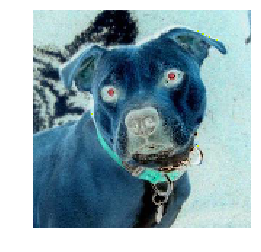

In [14]:
plt.axis("off")
plt.imshow(img_data, vmin=0, vmax=1)

How does Keras read the image to array? With respect to the color channels. And is this the same as the ImageDataGenerator does? We need the same inputs for scoring the new images.

It turns out that the img_show requires color data in the 0-1 domain. As the image array has 0-255 values we need to devide them by 255.

In [8]:
img_data_fraq = img_data / 255

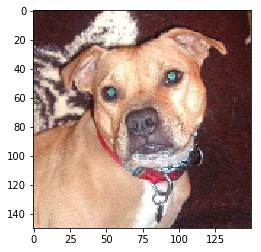

In [9]:
plt.imshow(img_data_fraq)

To test we can show the original one without transforming via arrays.

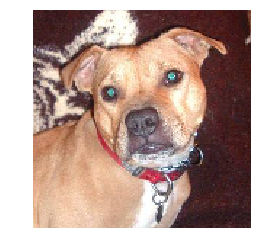

In [94]:
plt.axis("off")
plt.imshow(image)

**Loading the VGG model**

In [30]:
model = VGG16(include_top=False, weights='imagenet')

**Loading the top model**

In [16]:
top_model = load_model("top_model.h5")

In [26]:
input_data = np.expand_dims(img_data_fraq, axis=0)

In [27]:
input_data.shape

(1, 150, 150, 3)

In [31]:
pred1 = model.predict(input_data)

In [33]:
predictions = top_model.predict(pred1, batch_size=1)

In [34]:
predictions

array([[ 1.]], dtype=float32)

**Now create one function with the image name as input and which returns the prediction.**

In [37]:
def catPredictor(inp_img):
    vgg_model = VGG16(include_top=False, weights='imagenet')
    top_model = load_model("top_model.h5")
    # Load the image, put it in a numpy array and convert all color values to their fractions
    img_data = img_to_array(load_img(demo_file.format(fileno),
                                     grayscale=False,
                                     target_size=(img_height, img_width))
                           ) / 255
    img_data = np.expand_dims(img_data, axis=0)
    bottleneck_features = vgg_model.predict(img_data)
    prediction = top_model.predict(bottleneck_features)
    
    # Write a log
    log = open('scoring_log.csv', 'a')
    log.write('{},{}'.format(inp_img, prediction))
    return prediction

In [40]:
catPredictor('data/test/6.jpg')

array([[ 1.]], dtype=float32)

WRONG OUTPUT!

## Backup

In [4]:
def score_vgg16(img_dir):
    """
    
    :param img_dir: an existing directory with a sub folder per category which contains the images to be scored.
    :return: A Numpy array of predictions. The output of the last layer of the Conv block 5: MaxPooling. The Bottleneck features
    """
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network without the FC layers
    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        img_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    # All classes found as sub folder in img_dir
    n_classes = generator.num_class
    # Totaal amount of files found for all classes
    tot_samples = generator.samples
    
    # Original code
    # bottleneck_features = model.predict_generator(
    #    generator, nb_train_samples // batch_size)
    bottleneck_features = model.predict_generator(generator, (tot_samples / n_classes) // batch_size)
    print("VGG16 bottleneck features calculated.")
    return bottleneck_features

### The Top Layer model

In [5]:
def top_model(input_features, train = True):
    """
    
    :param input_features: A Numpy array of predictions.
    :param train: Boolean to indicate if the FC layers require to be trained or just score. Default set to train.
    :return: None if the layers are trained otherwise a Numpy array of predictions.
    """
    predictions = None
    
    model = Sequential()
    model.add(Flatten(input_shape=input_features.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    if train:
        # We assume and expect that there exists already two .npy files with the bottleneck features for training and validation
        train_data = np.load(open(bottleneck_features_train, 'rb'))
        train_labels = np.array([0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

        validation_data = np.load(open(bottleneck_features_validation, 'rb'))
        validation_labels = np.array([0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))
        
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        print("Top model compiled.")
        
        model.fit(train_data, train_labels,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(validation_data, validation_labels))
        model.save_weights(top_model_weights_path)
        print("Trained top-model weights saved as: {}".format(top_model_weights_path))
    else:
        # We assume and expect that there exists already a .h5 file with the pre-trained top layer model
        model.load_weights(top_model_weights_path)
        print("Top model weights loaded.")
        predictions = model.predict_classes(input_features)
        print("Predictions made.")
    
    return predictions

In [ ]:
def train_model(train_img_dir, validate_img_dir):
    
    np.save(open("bottleneck_features_train.npy", 'wb'), bottleneck_features_train)
    print("Training samples saved.")

In [6]:
folders = files = 0
for root, dirs, filenames in os.walk(test_dir):
    # Exclude hidden files
    filenames = [f for f in filenames if not f[0] == '.']
    dirs[:] = [d for d in dirs if not d[0] == '.']
    print("Directory: {} ({})".format(root, len(filenames)))
    files += len(filenames)
    folders += len(dirs)

print("{:,} files, {:,} folders".format(files, folders))

Directory: data/test_labeled (0)
Directory: data/test_labeled/cats (1000)
Directory: data/test_labeled/dogs (1000)
2,000 files, 2 folders


In [20]:
train_data = np.load(open(bottleneck_features_train, 'rb'))
train_labels = np.array([0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

Testing how the image data generator works.

In [26]:
datagen = ImageDataGenerator(rescale=1. / 255)
generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 2000 images belonging to 2 classes.


In [ ]:
def evaluate_model(test_path, overwrite=False):
    # Check if bottleneck features exist in case overwrite is False, we expect it already exists
    if overwrite == False:
        if !os.path.isfile(bottleneck_features_test):
            # If the file doesn't exist we will need to create it first
            overwrite = True
            
    # Get test data
    
    if overwrite:
        # Feed test data to vgg network
        test_data = score_vgg16(test_path)
        # Optional save the bottleneck features
        np.save(open(bottleneck_features_test, 'wb'), test_data)
        print("Bottleneck features for Test saved.")
    else:
        # Load bottleneck features
        test_data = np.load(open(bottleneck_features_test, 'rb'))
        
    # Get test data labels
    test_labels = np.array([0] * int(nb_test_samples / 2) + [1] * int(nb_test_samples / 2))
    # Get custom model
    # Feed features to custom model and get predictions
    # -> model.evaluate(test_data, test_labels, batch_size=batch_size)

Just run all test images through the VGG16 network and save the Bottleneck Features.

In [6]:
test_data = score_vgg16(test_dir)
np.save(open(bottleneck_features_test, 'wb'), test_data)
print("Bottleneck features for Test saved.")

Found 1000 images belonging to 2 classes.
VGG16 bottleneck features calculated.
Bottleneck features for Test saved.


Score the Test Bottleneck Features with the top model.

In [10]:
test_scores = top_model(test_data, False)

Top model weights loaded.
416/496 [========================>.....] - ETA: 0sPredictions made.
